In [1]:
import foton
import kontrol
import matplotlib.pyplot as plt
import numpy as np
import vishack
import scipy.signal
import control

In [2]:
# Load SRCL filters

# SRCL FM on
# FM 1, 2, 3, 4, 7, 9, 10
# Gain = 0.4
# Plant from M3 -> M3: FM 5 (M3 Force to M3 displacement)

srcl_ff = foton.FilterFile("foton_files/L1LSC.txt")
srcl_module = "LSC_SRCL"
srcl_bank = srcl_ff[srcl_module]
srcl_fm1 = srcl_bank[0]
srcl_fm2 = srcl_bank[1]
srcl_fm3 = srcl_bank[2]
srcl_fm4 = srcl_bank[3]
srcl_fm5 = srcl_bank[4]
srcl_fm6 = srcl_bank[5]
srcl_fm7 = srcl_bank[6]
srcl_fm8 = srcl_bank[7]
srcl_fm9 = srcl_bank[8]
srcl_fm10 = srcl_bank[9]

srcl_fm1_tf = kontrol.core.foton.get_zpk2tf(srcl_fm1.get_zpk())
srcl_fm2_tf = kontrol.core.foton.get_zpk2tf(srcl_fm2.get_zpk())
srcl_fm3_tf = kontrol.core.foton.get_zpk2tf(srcl_fm3.get_zpk())
srcl_fm4_tf = kontrol.core.foton.get_zpk2tf(srcl_fm4.get_zpk())
srcl_fm5_tf = kontrol.core.foton.get_zpk2tf(srcl_fm5.get_zpk())
srcl_fm6_tf = kontrol.core.foton.get_zpk2tf(srcl_fm6.get_zpk())
srcl_fm7_tf = kontrol.core.foton.get_zpk2tf(srcl_fm7.get_zpk())
srcl_fm8_tf = kontrol.core.foton.get_zpk2tf(srcl_fm8.get_zpk())
z, p, k = srcl_fm9.get_zpk()
for i in range(len(z)):
    imag = z[i].imag
    real = z[i].real
    if real/imag < 1e-9 and real > 0:
        z[i] = -real + 1j*imag
srcl_fm9_tf = kontrol.core.foton.get_zpk2tf((z, p, k))
srcl_fm10_tf = kontrol.core.foton.get_zpk2tf(srcl_fm10.get_zpk())

srcl_k = 0.4 * srcl_fm1_tf * srcl_fm2_tf * srcl_fm3_tf * srcl_fm4_tf * srcl_fm7_tf * srcl_fm9_tf * srcl_fm10_tf 

m3_m3_tf = -srcl_fm5_tf  # LIGO has a negative plant convention.

In [4]:
# Load M2 filters

# M2 LOCK FM on
# FM 1, 2, 3, 4, 5, 9
# Gain = 1.3
# Plant from M2 -> M3: FM 10 (M2 Force to M3 force)

m2_ff = foton.FilterFile("foton_files/L1SUSSR2.txt")
m2_module = "SR2_M2_LOCK_L"
m2_bank = m2_ff[m2_module]
m2_fm1 = m2_bank[0]
m2_fm2 = m2_bank[1]
m2_fm3 = m2_bank[2]
m2_fm4 = m2_bank[3]
m2_fm5 = m2_bank[4]
m2_fm6 = m2_bank[5]
m2_fm7 = m2_bank[6]
m2_fm8 = m2_bank[7]
m2_fm9 = m2_bank[8]
m2_fm10 = m2_bank[9]

m2_fm1_tf = kontrol.core.foton.get_zpk2tf(m2_fm1.get_zpk())
m2_fm2_tf = kontrol.core.foton.get_zpk2tf(m2_fm2.get_zpk())
m2_fm3_tf = kontrol.core.foton.get_zpk2tf(m2_fm3.get_zpk())
m2_fm4_tf = kontrol.core.foton.get_zpk2tf(m2_fm4.get_zpk())
# Fix M2_LOCK FM5 (flip small non-zero rhp zeros)
z, p, k = m2_fm5.get_zpk()
for i in range(len(z)):
    imag = z[i].imag
    real = z[i].real
    if real/imag < 1e-9 and real > 0:
        z[i] = -real + 1j*imag
m2_fm5_tf = kontrol.core.foton.get_zpk2tf((z, p, k))
m2_fm6_tf = kontrol.core.foton.get_zpk2tf(m2_fm6.get_zpk())
m2_fm7_tf = kontrol.core.foton.get_zpk2tf(m2_fm7.get_zpk())
m2_fm8_tf = kontrol.core.foton.get_zpk2tf(m2_fm8.get_zpk())
m2_fm9_tf = kontrol.core.foton.get_zpk2tf(m2_fm9.get_zpk())
m2_fm10_tf = kontrol.core.foton.get_zpk2tf(m2_fm10.get_zpk())

m2_k = 1.3 * m2_fm1_tf * m2_fm2_tf * m2_fm3_tf * m2_fm4_tf * m2_fm5_tf * m2_fm9_tf

m2_m3_tf = m2_fm10_tf  # No negative here.

In [66]:
# Load M1 filters

# M1 LOCK FM on
# FM 1,
# Gain = 1
# Plant from M1 -> M2: FM 10 # (M1 Force to M2 Force)

m1_ff = foton.FilterFile("foton_files/L1SUSSR2.txt")
m1_module = "SR2_M1_LOCK_L"
m1_bank = m1_ff[m1_module]
m1_fm1 = m1_bank[0]

m1_fm10 = m1_bank[9]

m1_fm1_tf = kontrol.core.foton.get_zpk2tf(m1_fm1.get_zpk())
z, p, k = m1_fm1.get_zpk()
for i in range(len(p)):
    if p[i] > 0 and p[i].real < 1e-6:
        p[i] = -p[i]
m1_fm1_tf = kontrol.core.foton.get_zpk2tf((z, p, k))

m1_fm10_tf = kontrol.core.foton.get_zpk2tf(m1_fm10.get_zpk())

m1_k = 1 * m1_fm1_tf

m1_m2_tf = -m1_fm10_tf  # LIGO has a negative plant convention.

In [6]:
m3_m3_gain = 1.5

In [60]:
k_srcl = srcl_k
k_m3 = m3_m3_gain
k_m2 = m2_k
k_m1 = m1_k
p_12 = m1_m2_tf 
p_23 = m2_m3_tf
p_33 = m3_m3_tf * 4
p_13 = p_12*p_23

p_13 *= 0.2548 / abs((k_m1*k_m2*p_13)(1j*2*np.pi*1))
p_23 *= 1.848 / abs((k_m2*p_23)(1j*2*np.pi*1))

In [67]:
f = np.logspace(-2, 3, 1024)

# frequency response of the OLTF
oltf = ((k_m3*p_33)(1j*2*np.pi*f) + (k_m2*p_23*p_33)(1j*2*np.pi*f) + (k_m2*k_m1*p_13*p_33)(1j*2*np.pi*f)) * k_srcl(1j*2*np.pi*f)

# Without M1 control
oltf_no_m1 = ((k_m3*p_33)(1j*2*np.pi*f) + (k_m2*p_23*p_33)(1j*2*np.pi*f)) * k_srcl(1j*2*np.pi*f)

# Without M1 and M2 control.
oltf_no_m1m2 = ((k_m3*p_33)(1j*2*np.pi*f)) * k_srcl(1j*2*np.pi*f)

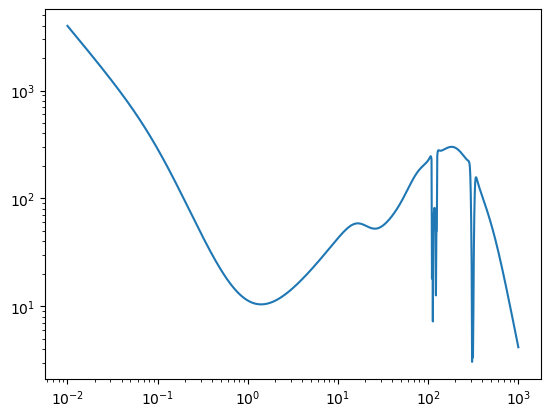

In [77]:
plt.loglog(f, abs(k_srcl(1j*2*np.pi*f)))

In [ ]:
# load measurement
data = vishack.data.diaggui.Diaggui("data/240228-SRCL_LN_45W.xml")
f_ = data.items.results.TF["L1:LSC-SRCL_IN2"].FHz
oltf_meas = data.items.results.TF["L1:LSC-SRCL_IN2"].xfer[1]
# f_, oltf_meas = data.tf("L1:LSC-SRCL_IN1", "L1:LSC-SRCL_IN1")

Text(0.5, 0, 'Frequency (Hz)')

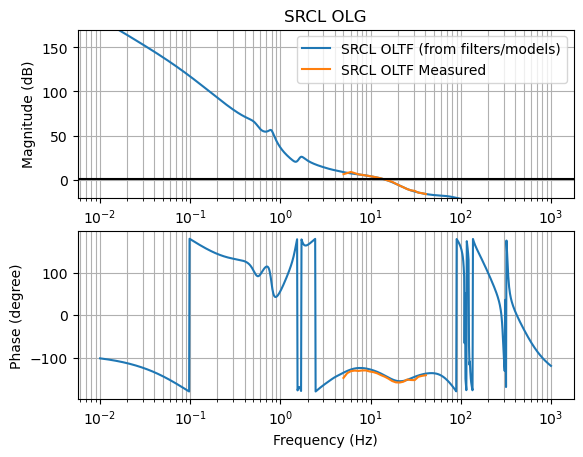

In [76]:
# Compare OLTF model and OLTF measurement.
# Measurement from LLO /data/dtt/Templates/LSC/240228-SRCL_LN_45W.xml
# Reference https://dcc.ligo.org/LIGO-G2100739

plt.subplot(211)
plt.title("SRCL OLG")
plt.semilogx(f, 20*np.log10(abs(oltf)), label="SRCL OLTF (from filters/models)")
# plt.semilogx(f, 20*np.log10(abs(oltf_no_m1)), label="SRCL OLTF (from filters/models) Without M1")
# plt.semilogx(f, 20*np.log10(abs(oltf_no_m1m2)), label="SRCL OLTF (from filters/models) Without M1, M2")
plt.semilogx(f_, 20*np.log10(abs(oltf_meas)), label="SRCL OLTF Measured")
plt.axhline(1, color="k")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude (dB)")
plt.yticks([0, 50, 100, 150])
plt.ylim(-20, 170)

plt.subplot(212)
plt.semilogx(f, np.angle(oltf, deg=True))
plt.semilogx(f_, np.angle(-oltf_meas.conj(), deg=True))
plt.grid(which="both")
plt.ylabel("Phase (degree)")
plt.xlabel("Frequency (Hz)")

In [87]:
np.savez("data/oltf_no_m1.npz", f=f, oltf_no_m1=oltf_no_m1)

In [88]:
np.savez("data/oltf.npz", f=f, oltf=oltf)

In [ ]:
# Export plant and controller for simulation

In [65]:
plant1 = (k_m3+k_m2*(p_23+k_m1*p_13))
z, p, k = scipy.signal.tf2zpk(plant1.num[0][0], plant1.den[0][0])

np.savez("model_params/plant1.npz", zs=z[:20], ps=p[:20], k=k)
np.savez("model_params/plant2.npz", zs=z[20:], ps=p[20:], k=1)

In [45]:
# No M1
plant1_no_m1 = (k_m3+k_m2*p_23)
z, p, k = scipy.signal.tf2zpk(plant1_no_m1.num[0][0], plant1_no_m1.den[0][0])
# np.savez("model_params/plant1_no_m1.npz", zs=z[:20], ps=p[:20], k=k)
# np.savez("model_params/plant2_no_m1.npz", zs=z[20:], ps=p[20:], k=1)

In [31]:
# M3 Plant
plant2 = p_33
z, p, k = scipy.signal.tf2zpk(plant2.num[0][0], plant2.den[0][0])
# np.savez("model_params/plant3.npz", zs=z, ps=p, k=k)

In [86]:
# SRCL controller
z, p, k = scipy.signal.tf2zpk(k_srcl.num[0][0], k_srcl.den[0][0])
np.savez("model_params/ctrl1.npz", zs=z[:18], ps=p[:19], k=k)
np.savez("model_params/ctrl2.npz", zs=z[18:], ps=p[19:], k=1)